# 01_data_raw

## 1️⃣ Loading raw wine production data

In this notebook, we will:

1. Load the raw wine production data per municipality (Excel file).
2. Inspect the first few rows to verify correctness.
3. Save the dataset as CSV for easier processing in later steps.

Once the raw data is prepared, we will also incorporate the **administrative boundaries of municipalities** in Alentejo from the Official Administrative Map of Portugal (CAOP).  
This will allow us to merge production data with geographic boundaries for spatial analysis and visualization later on.



In [7]:
# -----------------------------
# Importações e logging
# -----------------------------
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# -----------------------------
# Caminhos principais
# -----------------------------
input_path = Path(r"C:\Users\islec\climate-wine-project\data_raw\wine_production_raw.xlsx")
output_concelho = Path(r"C:\Users\islec\climate-wine-project\data_clean\wine_production_concelho.csv")
output_district = Path(r"C:\Users\islec\climate-wine-project\data_clean\wine_production_by_district.csv")
output_dir_viz_district = Path(r"C:\Users\islec\climate-wine-project\data_viz\wine_district_charts")
output_dir_viz_national = Path(r"C:\Users\islec\climate-wine-project\data_viz\national_summary")

# Criar pastas de saída, se não existirem
output_concelho.parent.mkdir(parents=True, exist_ok=True)
output_district.parent.mkdir(parents=True, exist_ok=True)
output_dir_viz_district.mkdir(parents=True, exist_ok=True)
output_dir_viz_national.mkdir(parents=True, exist_ok=True)

# -----------------------------
# Colunas
# -----------------------------
total_columns = ['TotalWine_Red', 'TotalWine_Rose', 'TotalWine_White', 'TotalWine_General']
columns_of_interest = ['Distrito', 'Concelho'] + total_columns

expected_columns = [
    'Distrito', 'Concelho',
    'Vinho_Tinto', 'Vinho_Rosado', 'Vinho_Branco', 'Vinho_Total',
    'IndCasta_Tinto', 'IndCasta_Rosado', 'IndCasta_Branco', 'IndCasta_Total',
    'IGP_Tinto', 'IGP_Rosado', 'IGP_Branco', 'IGP_Total',
    'LicorosoDOP_Tinto', 'LicorosoDOP_Rosado', 'LicorosoDOP_Branco', 'LicorosoDOP_Total',
    'DOP_Tinto', 'DOP_Rosado', 'DOP_Branco', 'DOP_Total',
    'TotalWine_Red', 'TotalWine_Rose', 'TotalWine_White', 'TotalWine_General'
]

# -----------------------------
# Funções
# -----------------------------
def read_excel(file_path: Path, sheet_index: int) -> pd.DataFrame:
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_index, header=None)
        logging.info(f"Excel sheet {sheet_index} read successfully from {file_path}")
        return df
    except Exception as e:
        logging.error(f"Error reading Excel file: {e}")
        raise

def rename_columns(df: pd.DataFrame) -> pd.DataFrame:
    if len(df.columns) != len(expected_columns):
        raise ValueError(f"Expected {len(expected_columns)} columns, found {len(df.columns)}")
    df.columns = expected_columns
    logging.info("Columns renamed successfully")
    return df

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df_clean = df[[c for c in columns_of_interest if c in df.columns]].copy()
    df_clean = df_clean.dropna(how='all')
    df_clean = df_clean[~df_clean['Distrito'].astype(str).str.contains('Produção|Total|Distrito', na=False)]
    df_clean['Distrito'] = df_clean['Distrito'].ffill()
    df_clean = df_clean[df_clean['Concelho'].notna()].reset_index(drop=True)
    
    for col in total_columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').fillna(0).round(0).astype(int)
    
    logging.info("Data cleaned and formatted successfully")
    return df_clean

def save_to_csv(df: pd.DataFrame, output_path: Path):
    df.to_csv(output_path, index=False, encoding='utf-8')
    logging.info(f"CSV saved successfully at {output_path}")

def display_table(df: pd.DataFrame, rows: int = 10, caption: str = "Table"):
    display(df.head(rows).style.set_caption(caption))


In [8]:
# -----------------------------
# Ler e processar dados
# -----------------------------
df = read_excel(input_path, sheet_index=22)
df = rename_columns(df)
df_clean_concelho = clean_data(df)

# -----------------------------
# Salvar CSV por concelho
# -----------------------------
save_to_csv(df_clean_concelho, output_concelho)
display_table(df_clean_concelho, rows=10, caption="Wine Production by Municipality")
logging.info(f"CSV by Municipality generated at: {output_concelho}")

# -----------------------------
# Totais por distrito
# -----------------------------
df_clean_district = df_clean_concelho.groupby('Distrito')[total_columns].sum().reset_index()
save_to_csv(df_clean_district, output_district)
display_table(df_clean_district, rows=10, caption="Wine Production by District")
logging.info(f"CSV with totals by District generated at: {output_district}")


INFO: Excel sheet 22 read successfully from C:\Users\islec\climate-wine-project\data_raw\wine_production_raw.xlsx
INFO: Columns renamed successfully
INFO: Data cleaned and formatted successfully
INFO: CSV saved successfully at C:\Users\islec\climate-wine-project\data_clean\wine_production_concelho.csv


,Distrito,Concelho,TotalWine_Red,TotalWine_Rose,TotalWine_White,TotalWine_General
0,Aveiro,Águeda,1362,1666,3432,6459
1,Aveiro,Albergaria-a-Velha,223,21,265,509
2,Aveiro,Anadia,29328,35995,34513,99837
3,Aveiro,Arouca,95,0,267,363
4,Aveiro,Aveiro,62,0,18,80
5,Aveiro,Castelo de Paiva,5354,86,14811,20250
6,Aveiro,Estarreja,14,6,21,41
7,Aveiro,Ílhavo,18,11,0,29
8,Aveiro,Mealhada,4015,1618,4522,10155
9,Aveiro,Oliveira de Azeméis,0,0,8,8


INFO: CSV by Municipality generated at: C:\Users\islec\climate-wine-project\data_clean\wine_production_concelho.csv
INFO: CSV saved successfully at C:\Users\islec\climate-wine-project\data_clean\wine_production_by_district.csv


,Distrito,TotalWine_Red,TotalWine_Rose,TotalWine_White,TotalWine_General
0,Aveiro,44550,40519,65022,150092
1,Açores,1413,209,2042,3663
2,Beja,154990,7766,72344,235101
3,Braga,37130,12934,208243,258308
4,Bragança,121182,43836,27664,192683
5,Castelo Branco,9499,132,2111,11742
6,Coimbra,20769,6870,25629,53268
7,Faro,10750,2806,7603,21156
8,Guarda,342219,20795,87595,450612
9,Leiria,62236,6978,27971,97183


INFO: CSV with totals by District generated at: C:\Users\islec\climate-wine-project\data_clean\wine_production_by_district.csv


INFO: Saved chart for Aveiro at C:\Users\islec\climate-wine-project\data_viz\wine_district_charts\Aveiro.png
INFO: Saved chart for Açores at C:\Users\islec\climate-wine-project\data_viz\wine_district_charts\Açores.png
INFO: Saved chart for Beja at C:\Users\islec\climate-wine-project\data_viz\wine_district_charts\Beja.png
INFO: Saved chart for Braga at C:\Users\islec\climate-wine-project\data_viz\wine_district_charts\Braga.png
INFO: Saved chart for Bragança at C:\Users\islec\climate-wine-project\data_viz\wine_district_charts\Bragança.png
INFO: Saved chart for Castelo Branco at C:\Users\islec\climate-wine-project\data_viz\wine_district_charts\Castelo_Branco.png
INFO: Saved chart for Coimbra at C:\Users\islec\climate-wine-project\data_viz\wine_district_charts\Coimbra.png
INFO: Saved chart for Faro at C:\Users\islec\climate-wine-project\data_viz\wine_district_charts\Faro.png
INFO: Saved chart for Guarda at C:\Users\islec\climate-wine-project\data_viz\wine_district_charts\Guarda.png
INFO: S

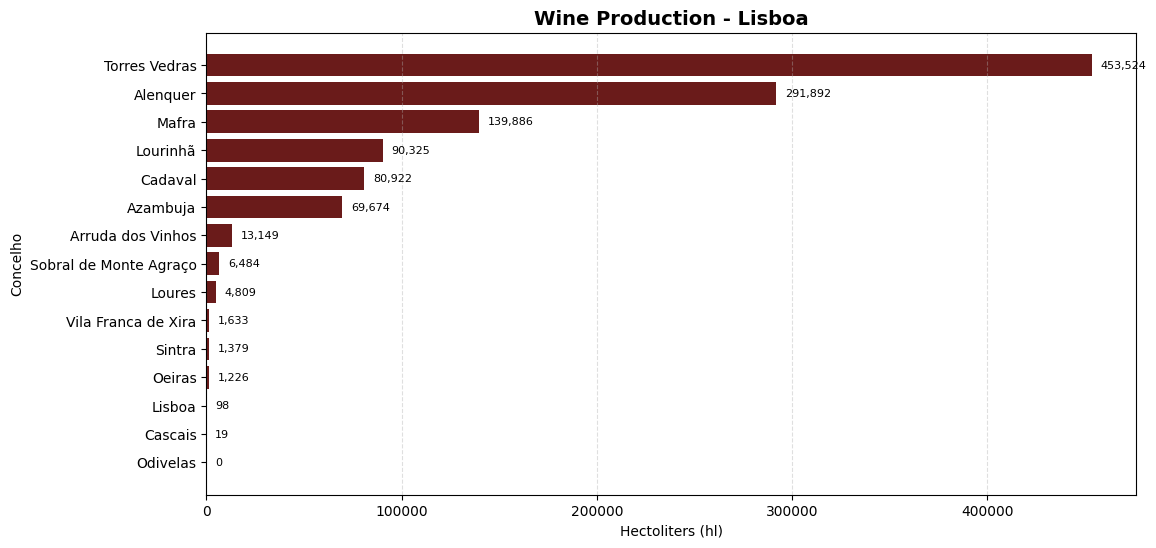

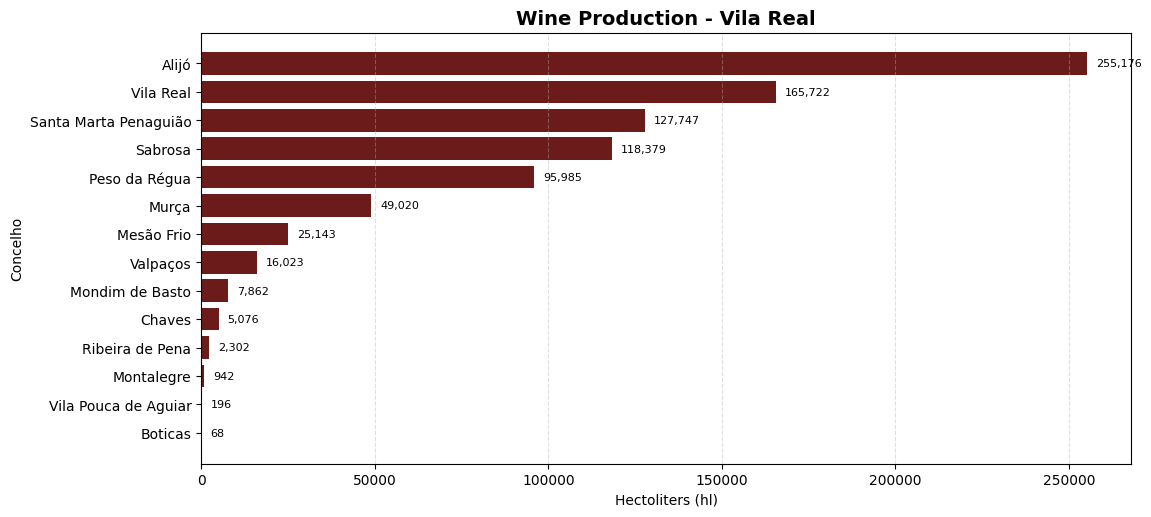

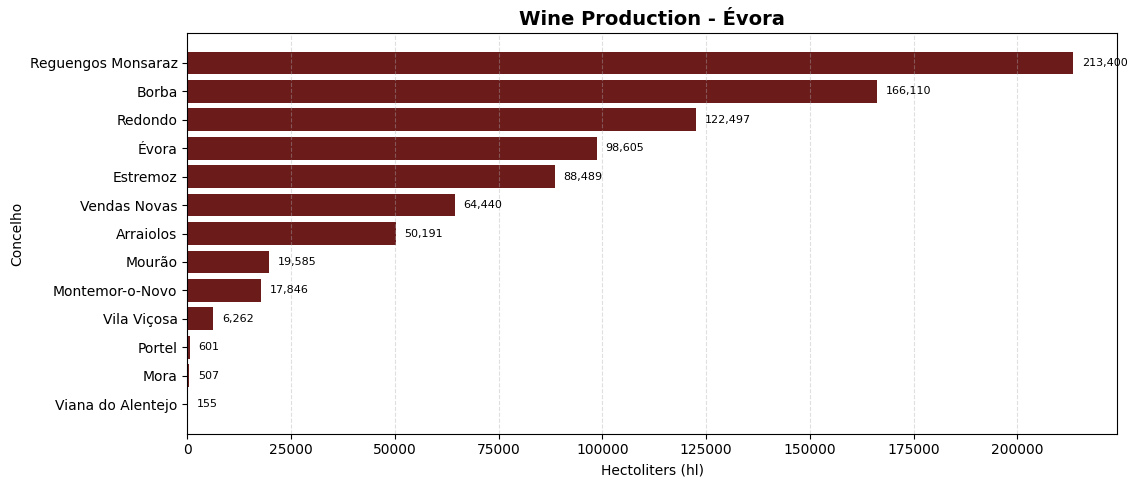

INFO: District charts saved in C:\Users\islec\climate-wine-project\data_viz\wine_district_charts


=== National Wine Production ===
TotalWine_Red        3933674
TotalWine_Rose        475028
TotalWine_White      2515434
TotalWine_General    6924131
dtype: int64

Percentage of each type:
TotalWine_Red      56.81
TotalWine_Rose      6.86
TotalWine_White    36.33
dtype: float64


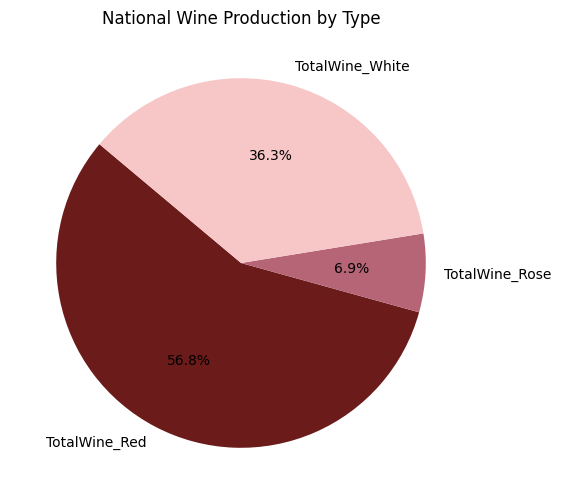

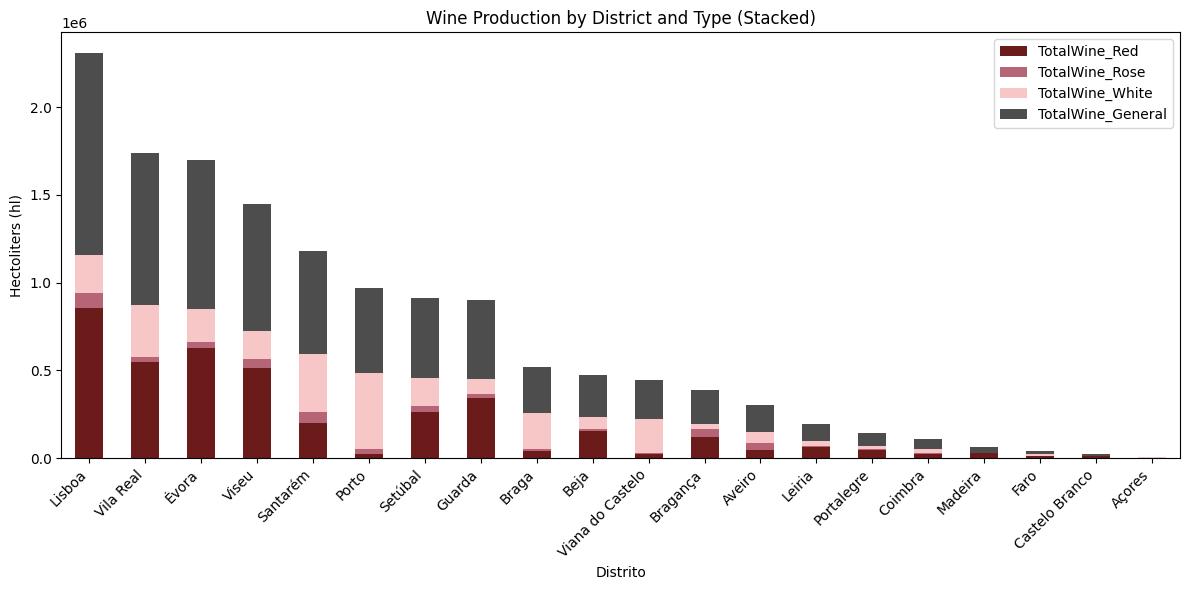

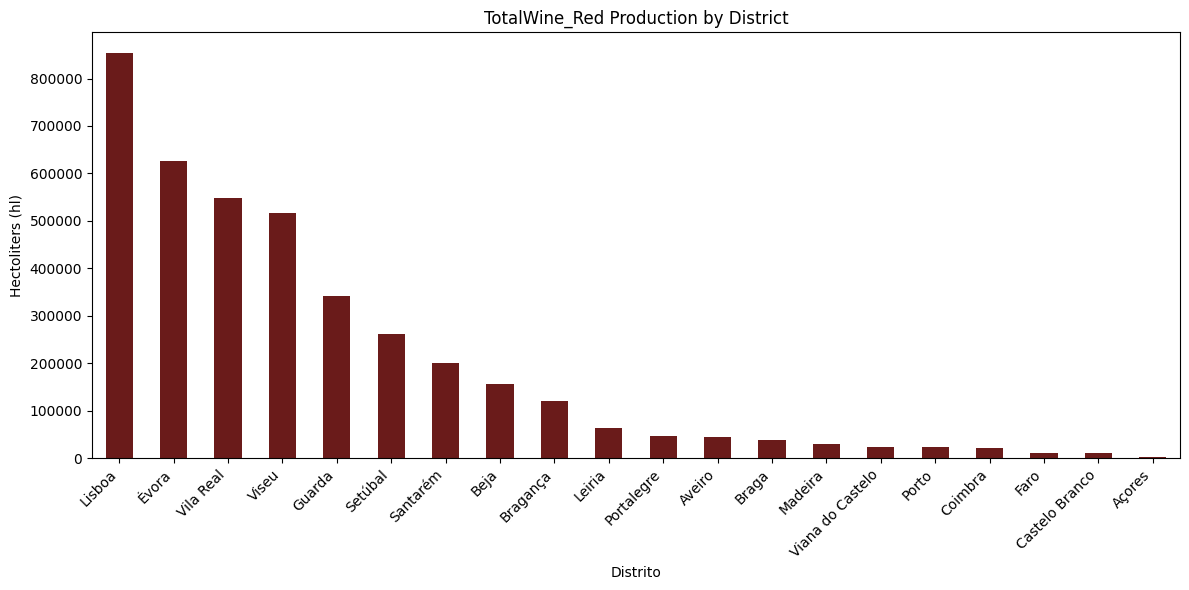

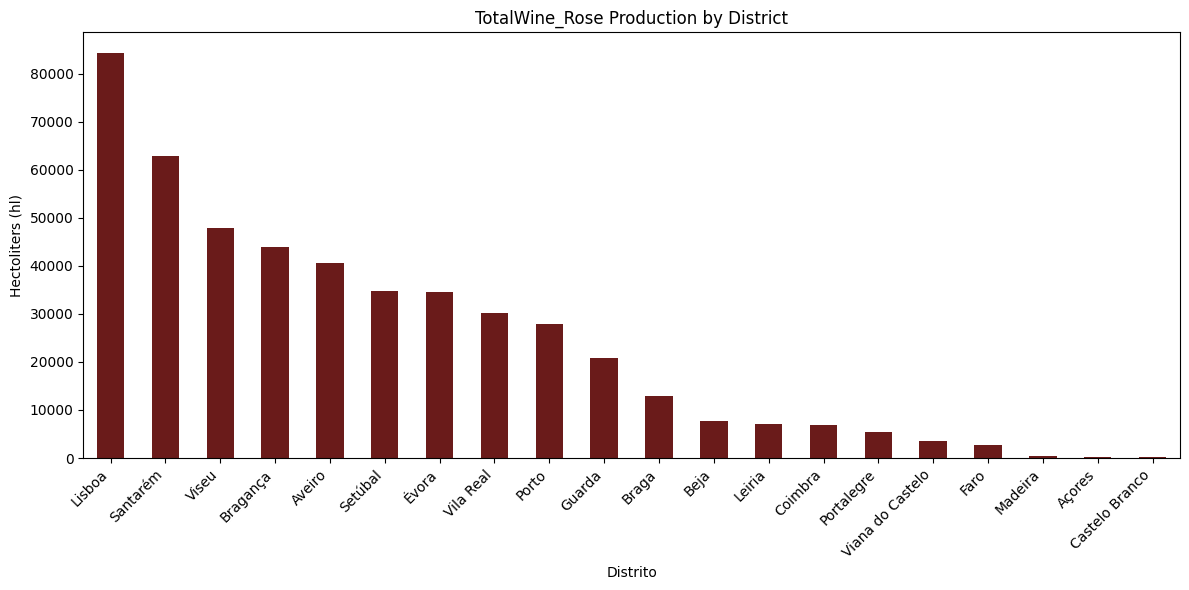

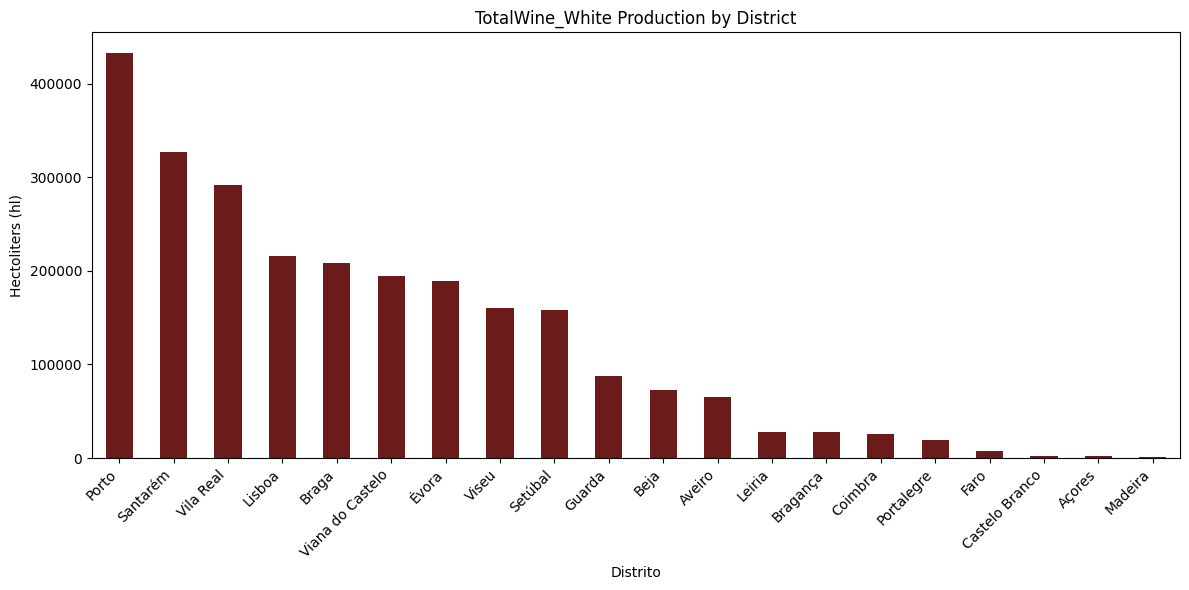

INFO: National summary charts saved in C:\Users\islec\climate-wine-project\data_viz\national_summary


All national summary charts saved in folder: C:\Users\islec\climate-wine-project\data_viz\national_summary


In [9]:
# -----------------------------
# Usar df_clean_concelho como base
# -----------------------------
df_clean = df_clean_concelho  # garante que todas as funções de gráficos funcionem

# -----------------------------
# Gráficos por distrito
# -----------------------------
def plot_district(df_dist, distrito, save_path=None):
    df_plot = df_dist.sort_values('TotalWine_General', ascending=True)
    if df_plot.empty:
        logging.warning(f"No data for district {distrito}, skipping.")
        return None
    
    num_concelhos = len(df_plot)
    fig, ax = plt.subplots(figsize=(12, max(4, num_concelhos*0.4)))
    bars = ax.barh(df_plot['Concelho'], df_plot['TotalWine_General'], color='#6a1b1a')
    
    ax.set_title(f"Wine Production - {distrito}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Hectoliters (hl)")
    ax.set_ylabel("Concelho")
    ax.grid(axis='x', linestyle='--', alpha=0.4)
    
    for bar in bars:
        width = bar.get_width()
        ax.text(width + max(df_plot['TotalWine_General'])*0.01,
                bar.get_y() + bar.get_height()/2,
                f"{width:,.0f}", va='center', fontsize=8)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        logging.info(f"Saved chart for {distrito} at {save_path}")
        return save_path
    else:
        plt.show()
        plt.close()
        return None

saved_files = []
for distrito, df_dist in df_clean.groupby('Distrito'):
    safe_name = "".join(c if c.isalnum() else "_" for c in distrito)
    viz_path = output_dir_viz_district / f"{safe_name}.png"
    saved_file = plot_district(df_dist, distrito, save_path=viz_path)
    if saved_file:
        saved_files.append(saved_file)

# Top 3 distritos
district_totals = df_clean.groupby('Distrito')[total_columns].sum()
top_distritos = district_totals['TotalWine_General'].nlargest(3).index
for distrito in top_distritos:
    df_dist = df_clean[df_clean['Distrito']==distrito]
    plot_district(df_dist, distrito, save_path=None)

logging.info(f"District charts saved in {output_dir_viz_district}")

# -----------------------------
# Gráficos nacionais
# -----------------------------
types_only = ['TotalWine_Red','TotalWine_Rose','TotalWine_White']
all_columns = types_only + ['TotalWine_General']

totals_national = df_clean[all_columns].sum()
percentages = totals_national[types_only]/totals_national[types_only].sum()*100

print("=== National Wine Production ===")
print(totals_national)
print("\nPercentage of each type:")
print(percentages.round(2))

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(totals_national[types_only], labels=types_only,
        autopct='%1.1f%%', startangle=140,
        colors=['#6a1b1a','#b56576','#f7c6c7'])
plt.title("National Wine Production by Type")
plt.savefig(output_dir_viz_national / "national_wine_pie.png", dpi=300, bbox_inches='tight')
plt.show()

# Stacked bar
district_totals = df_clean.groupby('Distrito')[all_columns].sum().sort_values('TotalWine_General', ascending=False)
district_totals.plot(kind='bar', stacked=True, figsize=(12,6),
                     color=['#6a1b1a','#b56576','#f7c6c7','#4d4d4d'])
plt.ylabel("Hectoliters (hl)")
plt.title("Wine Production by District and Type (Stacked)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(output_dir_viz_national / "national_wine_stacked_bar.png", dpi=300, bbox_inches='tight')
plt.show()

# Separate bar charts
for wine_type in types_only:
    plt.figure(figsize=(12,6))
    district_totals[wine_type].sort_values(ascending=False).plot(kind='bar', color='#6a1b1a')
    plt.ylabel("Hectoliters (hl)")
    plt.title(f"{wine_type} Production by District")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(output_dir_viz_national / f"{wine_type}_by_district.png", dpi=300, bbox_inches='tight')
    plt.show()

logging.info(f"National summary charts saved in {output_dir_viz_national}")
print(f"All national summary charts saved in folder: {output_dir_viz_national}")


## 2️⃣ Loading Municipal Boundaries (CAOP)

So far, we have loaded and processed the wine production data per municipality.  
To complement our analysis and enable geographic visualizations, we will now import the **administrative boundaries of municipalities** in Alentejo from the Official Administrative Map of Portugal (CAOP).  

This step will allow us to:

- Filter only the municipalities in Alentejo.
- Merge the wine production data with geographic boundaries.
- Create maps and perform spatial analyses later on.

By doing this, our dataset will be complete and ready for more advanced analysis and visualizations.



<Figure size 1200x1200 with 0 Axes>

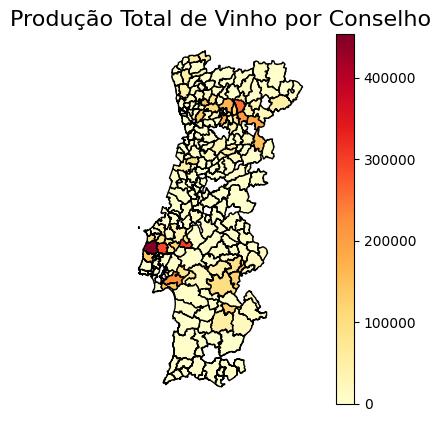

<Figure size 1200x1200 with 0 Axes>

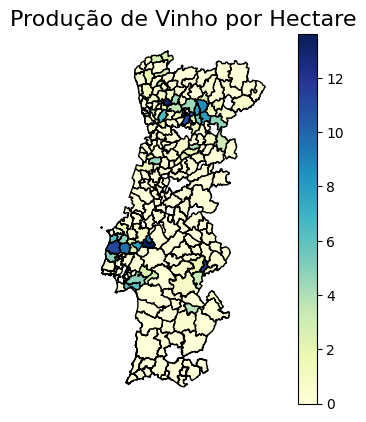

✅ Mapas salvos em data_viz!


In [36]:
# 📌 Notebook enxuto - Produção de Vinho em Alentejo

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Carregar GeoDataFrame dos municípios/concelhos
# -----------------------------
munis = gpd.read_file(
    r"C:\Users\islec\climate-wine-project\data_raw\Portugal_conselhos.gpkg", 
    layer="cont_municipios"
)

# -----------------------------
# 2️⃣ Carregar CSV de produção por concelho
# -----------------------------
wine_data = pd.read_csv(
    r"C:\Users\islec\climate-wine-project\data_clean\wine_production_concelho.csv"
)

# -----------------------------
# 3️⃣ Merge entre dados geográficos e produção
# -----------------------------
# GeoPackage: 'municipio', CSV: 'Concelho'
munis_wine = munis.merge(
    wine_data, 
    left_on="municipio", 
    right_on="Concelho", 
    how='left'
)

# -----------------------------
# 4️⃣ Mapas de produção
# -----------------------------

# 4a️⃣ Produção total por município (escala linear)
plt.figure(figsize=(12,12))
munis_wine.plot(
    column='TotalGeral_Total',  
    cmap='YlOrRd',
    legend=True,
    edgecolor='black'
)
plt.title("Produção Total de Vinho por Conselho", fontsize=16)
plt.axis('off')
plt.show()

# 4b️⃣ Produção por hectare (eficiência)
munis_wine['Prod_por_ha'] = munis_wine['TotalGeral_Total'] / munis_wine['area_ha']

plt.figure(figsize=(12,12))
munis_wine.plot(
    column='Prod_por_ha',  
    cmap='YlGnBu',
    legend=True,
    edgecolor='black'
)
plt.title("Produção de Vinho por Hectare", fontsize=16)
plt.axis('off')
plt.show()
# -----------------------------
# 5️⃣ Salvar mapas como imagens no data_viz
# -----------------------------
import os

# Criar pasta se não existir
output_map_dir = r"C:\Users\islec\climate-wine-project\data_viz"
os.makedirs(output_map_dir, exist_ok=True)

# Dicionário com mapas e colunas
mapas = {
    "Producao_Total": "TotalGeral_Total",
    "Producao_por_ha": "Prod_por_ha"
}

for nome, coluna in mapas.items():
    fig, ax = plt.subplots(figsize=(12,12))
    munis_wine.plot(
        column=coluna,
        cmap='YlOrRd' if coluna=="TotalGeral_Total" else 'YlGnBu',
        legend=True,
        edgecolor='black',
        ax=ax
    )
    ax.set_title(nome.replace("_", " "), fontsize=16)
    ax.axis('off')
    # Salvar no data_viz
    fig.savefig(os.path.join(output_map_dir, f"{nome}.png"), dpi=300)
    plt.close(fig)

print("✅ Mapas salvos em data_viz!")



<Figure size 1200x1200 with 0 Axes>

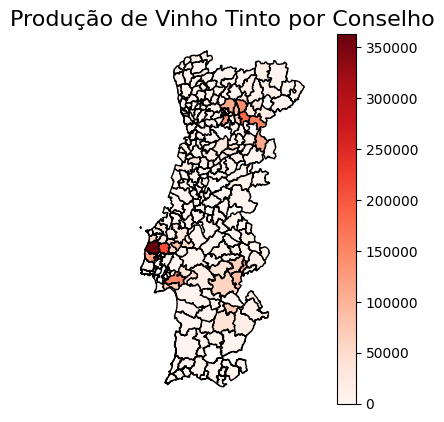

<Figure size 1200x1200 with 0 Axes>

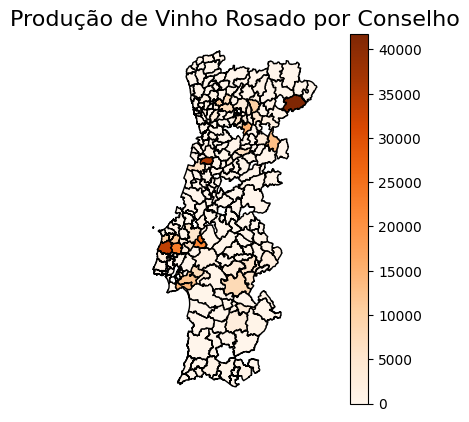

<Figure size 1200x1200 with 0 Axes>

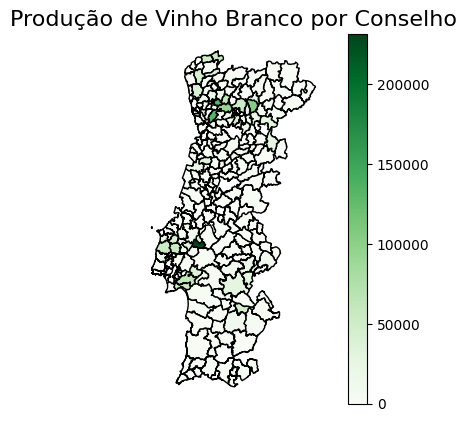

✅ Mapas de tinto, rosado e branco salvos em data_viz!


In [37]:
# 📌 Notebook enxuto - Produção de Vinho em Alentejo (Total + Tipos)

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Carregar GeoDataFrame dos municípios/concelhos
# -----------------------------
munis = gpd.read_file(
    r"C:\Users\islec\climate-wine-project\data_raw\Portugal_conselhos.gpkg", 
    layer="cont_municipios"
)

# -----------------------------
# 2️⃣ Carregar CSV de produção por concelho
# -----------------------------
wine_data = pd.read_csv(
    r"C:\Users\islec\climate-wine-project\data_clean\wine_production_concelho.csv"
)

# -----------------------------
# 3️⃣ Merge entre dados geográficos e produção
# -----------------------------
munis_wine = munis.merge(
    wine_data, 
    left_on="municipio", 
    right_on="Concelho", 
    how='left'
)

# -----------------------------
# 4️⃣ Mapas de produção
# -----------------------------

# 4c️⃣ Produção por tipo de vinho
tipos = ['TotalGeral_Tinto', 'TotalGeral_Rosado', 'TotalGeral_Branco']
cmap_dict = {'TotalGeral_Tinto':'Reds', 'TotalGeral_Rosado':'Oranges', 'TotalGeral_Branco':'Greens'}

for tipo in tipos:
    plt.figure(figsize=(12,12))
    munis_wine.plot(
        column=tipo,
        cmap=cmap_dict[tipo],
        legend=True,
        edgecolor='black'
    )
    plt.title(f"Produção de Vinho {tipo.split('_')[-1]} por Conselho", fontsize=16)
    plt.axis('off')
    plt.show()
    # -----------------------------
# 5️⃣ Salvar mapas por tipo de vinho no data_viz
# -----------------------------
import os

output_map_dir = r"C:\Users\islec\climate-wine-project\data_viz"
os.makedirs(output_map_dir, exist_ok=True)

for tipo in tipos:
    fig, ax = plt.subplots(figsize=(12,12))
    munis_wine.plot(
        column=tipo,
        cmap=cmap_dict[tipo],
        legend=True,
        edgecolor='black',
        ax=ax
    )
    ax.set_title(f"Produção de Vinho {tipo.split('_')[-1]} por Conselho", fontsize=16)
    ax.axis('off')
    # Salvar no data_viz
    fig.savefig(os.path.join(output_map_dir, f"{tipo}.png"), dpi=300)
    plt.close(fig)

print("✅ Mapas de tinto, rosado e branco salvos em data_viz!")



=== National Wine Production ===
TotalGeral_Tinto     3933674
TotalGeral_Rosado     475028
TotalGeral_Branco    2515434
TotalGeral_Total     6924131
dtype: int64

Percentage of each type:
TotalGeral_Tinto     28.41
TotalGeral_Rosado     3.43
TotalGeral_Branco    18.16
TotalGeral_Total     50.00
dtype: float64

=== Descriptive Statistics per Type ===


,count,mean,std,min,25%,50%,75%,max,percentage_of_total
TotalGeral_Tinto,272.0,14462.036765,38517.765299,0.0,83.0,1150.0,7242.75,362592.0,56.811086
TotalGeral_Rosado,272.0,1746.426471,5112.900127,0.0,0.0,57.5,767.50,41746.0,6.860471
TotalGeral_Branco,272.0,9247.919118,23227.975522,0.0,55.0,538.0,6480.75,231591.0,36.328515
TotalGeral_Total,272.0,25456.363971,56525.565857,0.0,177.5,2208.0,19658.75,453524.0,100.000000


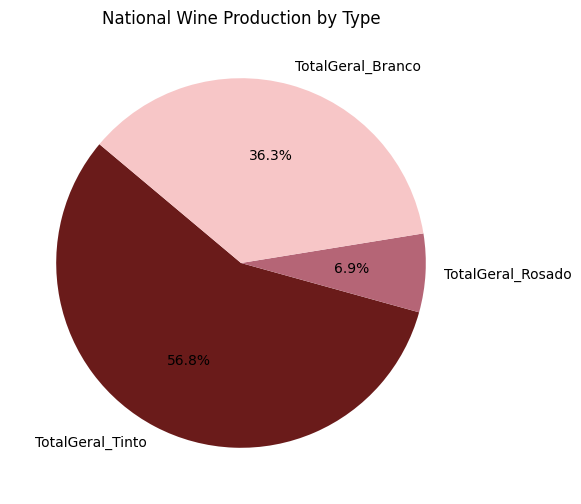

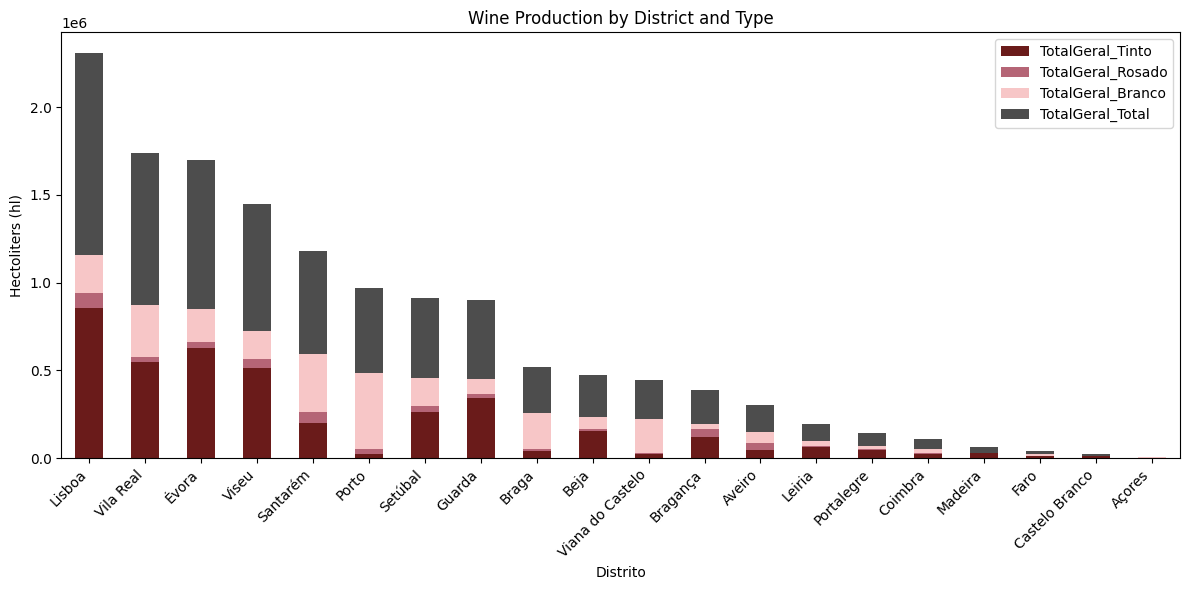

INFO: National summary charts saved in C:\Users\islec\climate-wine-project\data_viz\national_summary


In [61]:
# Define folder to save visuals
output_dir_viz = Path(r"C:\Users\islec\climate-wine-project\data_viz\national_summary")
output_dir_viz.mkdir(parents=True, exist_ok=True)

# -----------------------------
# Total production per type
# -----------------------------
totals_national = df_clean[total_columns].sum()
percentages = totals_national / totals_national.sum() * 100

print("=== National Wine Production ===")
print(totals_national)
print("\nPercentage of each type:")
print(percentages.round(2))

# -----------------------------
# Descriptive statistics
# -----------------------------
stats = df_clean[total_columns].describe().T  # transpose for easier reading
stats['percentage_of_total'] = (stats['mean'] * len(df_clean)) / totals_national['TotalGeral_Total'] * 100
print("\n=== Descriptive Statistics per Type ===")
display(stats)

# -----------------------------
# Pie chart: wine type distribution
# -----------------------------
plt.figure(figsize=(6,6))
plt.pie(totals_national[:-1], labels=totals_national.index[:-1], autopct='%1.1f%%', startangle=140,
        colors=['#6a1b1a', '#b56576', '#f7c6c7'])
plt.title("National Wine Production by Type")
plt.savefig(output_dir_viz / "national_wine_pie.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# Stacked bar: production by district
# -----------------------------
district_totals = df_clean.groupby('Distrito')[total_columns].sum().sort_values('TotalGeral_Total', ascending=False)
district_totals.plot(kind='bar', stacked=True, figsize=(12,6),
                     color=['#6a1b1a', '#b56576', '#f7c6c7', '#4d4d4d'])
plt.ylabel("Hectoliters (hl)")
plt.title("Wine Production by District and Type")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(output_dir_viz / "national_wine_stacked_bar.png", dpi=300, bbox_inches='tight')
plt.show()

logging.info(f"National summary charts saved in {output_dir_viz}")